In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


### Load the Preprocessed Data

In [100]:

df = pd.read_csv('Data/processed/FC110568_Dilini/preprocessed_data.csv')

print("DataFrame Dimensions")
print("------------------------")
print(f"   Rows   : {df.shape[0]}")
print(f"   Columns: {df.shape[1]}")

DataFrame Dimensions
------------------------
   Rows   : 27889
   Columns: 13


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27889 entries, 0 to 27888
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27889 non-null  object 
 1   Age                                    27889 non-null  float64
 2   Academic Pressure                      27889 non-null  float64
 3   CGPA                                   27889 non-null  float64
 4   Study Satisfaction                     27889 non-null  float64
 5   Sleep Duration                         27889 non-null  float64
 6   Dietary Habits                         27889 non-null  object 
 7   Degree                                 27889 non-null  object 
 8   Have you ever had suicidal thoughts ?  27889 non-null  object 
 9   Work/Study Hours                       27889 non-null  float64
 10  Financial Stress                       27889 non-null  float64
 11  Fa

In [102]:
# Convert all object columns to category dtype in df
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

# Check dtypes to confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27889 entries, 0 to 27888
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Gender                                 27889 non-null  category
 1   Age                                    27889 non-null  float64 
 2   Academic Pressure                      27889 non-null  float64 
 3   CGPA                                   27889 non-null  float64 
 4   Study Satisfaction                     27889 non-null  float64 
 5   Sleep Duration                         27889 non-null  float64 
 6   Dietary Habits                         27889 non-null  category
 7   Degree                                 27889 non-null  category
 8   Have you ever had suicidal thoughts ?  27889 non-null  category
 9   Work/Study Hours                       27889 non-null  float64 
 10  Financial Stress                       27889 non-null  flo

## Data Splitting & Encoding

For machine learning, we need numeric features. So the Encoding is the process of converting text into numbers.

**Ordinal Encoding**

 The 'Degree' feature has a natural ordinal order (e.g., 'Class 12' < 'BA' < 'BSc' < 'BCA' < 'B.Pharm' < 'M.Tech' < 'MSc' < 'MD'), so it will be encoded using ordinal encoding to preserve this order for machine learning models.

 - School (Class 12) -> 0
- Bachelor's (B.*) -> 1
- Master's (M.*) -> 2
- Doctorate (PhD) -> 3
- Other -> 4

In [103]:

# Data Splitting - Test 20% & Train 80%
# Ensure 'Depression' is the target variable and exists in the DataFrame

X = df.drop("Depression", axis=1)
y = df["Depression"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define updated function to group degrees more accurately
def simplify_degree(degree):
    if pd.isnull(degree):
        return 'Other'
    
    degree = degree.strip().lower()

    # School level
    if 'class 12' in degree:
        return 'School'
    
    # Doctorate level
    elif 'phd' in degree:
        return 'Doctorate'

    # Master’s level
    elif degree.startswith('m') or degree in ['msc', 'm.tech', 'mca', 'mba', 'm.ed', 'mhm']:
        return 'Master'

    # Bachelor's level
    elif degree.startswith('b') or degree in ['bsc', 'ba', 'bca', 'bba', 'b.com', 'b.tech', 'b.ed', 'b.arch', 'b.pharm']:
        return 'Bachelor'

    # Everything else
    else:
        return 'Other'

# Apply function
if 'X_train' in locals() and 'X_test' in locals():

    X_train['Degree_Grouped'] = X_train['Degree'].apply(simplify_degree)
    X_test['Degree_Grouped'] = X_test['Degree'].apply(simplify_degree)

    # Map to ordinal encoding
    degree_order = {
        'School': 0,
        'Bachelor': 1,
        'Master': 2,
        'Doctorate': 3,
        'Other': 4
    }

    X_train['Degree_Encoded'] = X_train['Degree_Grouped'].map(degree_order)
    X_test['Degree_Encoded'] = X_test['Degree_Grouped'].map(degree_order)

else:
    print("Please define the data splitting variables first.")

# Preview results
print("Encoded Training Data Columns:")
print(X_train[['Degree', 'Degree_Grouped', 'Degree_Encoded']].head(20))
print("\nEncoded Test Data Columns:")
print("\n",X_test[['Degree', 'Degree_Grouped', 'Degree_Encoded']].head(5))

# Drop original and grouped degree columns
if 'Degree' in X_train.columns and 'Degree_Grouped' in X_train.columns:
    X_train.drop(columns=['Degree', 'Degree_Grouped'], inplace=True)
    X_test.drop(columns=['Degree', 'Degree_Grouped'], inplace=True)


Encoded Training Data Columns:
           Degree Degree_Grouped  Degree_Encoded
20912         MCA         Master               2
11163         BSc       Bachelor               1
4099   'Class 12'         School               0
25142  'Class 12'         School               0
19006  'Class 12'         School               0
15583  'Class 12'         School               0
16582         MBA         Master               2
10163         BCA       Bachelor               1
16129  'Class 12'         School               0
1276        M.Com         Master               2
10016         BCA       Bachelor               1
23408  'Class 12'         School               0
10019         MSc         Master               2
10280      B.Tech       Bachelor               1
11606      B.Arch       Bachelor               1
23363       M.Com         Master               2
5019   'Class 12'         School               0
27609      B.Arch       Bachelor               1
8616        B.Com       Bachelor      

**One - hot Encoding**

In [119]:
# List of categorical columns to encode
categorical_columns = [
    'Gender',
    'Dietary Habits',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness'
]

# Apply one-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=False)

# Align both train and test to ensure same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print("Encoded Training Data Columns:")
print(X_train_encoded)
print("\nEncoded Test Data Columns:")
print(X_test_encoded)





Encoded Training Data Columns:
        Age  Academic Pressure  CGPA  Study Satisfaction  Sleep Duration  \
20912  25.0                4.0  7.35                 1.0             5.5   
11163  23.0                1.0  5.32                 2.0             5.0   
4099   20.0                5.0  8.25                 1.0             8.0   
25142  18.0                3.0  8.04                 5.0             7.5   
19006  19.0                3.0  7.10                 2.0             5.0   
...     ...                ...   ...                 ...             ...   
21575  25.0                4.0  5.64                 4.0             7.5   
5390   20.0                3.0  5.82                 1.0             8.0   
860    18.0                5.0  6.37                 3.0             5.0   
15795  30.0                3.0  8.90                 3.0             8.0   
23654  33.0                4.0  8.04                 3.0             5.0   

       Work/Study Hours  Financial Stress  Degree_Encode

In [ ]:
print("Training Data Types:")
print(X_train.dtypes)      
print("\nEncoded Training Data Types:")    
print(X_train_encoded.dtypes)  

Training Data Types:

Encoded Training Data Types:
Age                                          float64
Academic Pressure                            float64
CGPA                                         float64
Study Satisfaction                           float64
Sleep Duration                               float64
Work/Study Hours                             float64
Financial Stress                             float64
Degree_Encoded                                 int64
Gender_Female                                   bool
Gender_Male                                     bool
Dietary Habits_Healthy                          bool
Dietary Habits_Moderate                         bool
Dietary Habits_Unhealthy                        bool
Have you ever had suicidal thoughts ?_No        bool
Have you ever had suicidal thoughts ?_Yes       bool
Family History of Mental Illness_No             bool
Family History of Mental Illness_Yes            bool
dtype: object


In [105]:
print("Checking for missing values in training sets:")
print(X_train.isnull().sum())
print("\nChecking for missing values in test sets:")
print(X_test.isnull().sum())

Checking for missing values in training sets:
Gender                                   0
Age                                      0
Academic Pressure                        0
CGPA                                     0
Study Satisfaction                       0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Degree_Encoded                           0
dtype: int64

Checking for missing values in test sets:
Gender                                   0
Age                                      0
Academic Pressure                        0
CGPA                                     0
Study Satisfaction                       0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                      

## Random Forest Base Model Training and Evaluation

#### Initialize and Train Baseline Model

In [122]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Make Prediction

In [108]:
y_pred = rf_model.predict(X_test_encoded)

#### Evaluate Model Performance

In [109]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8361419863750448

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      2350
           1       0.85      0.87      0.86      3228

    accuracy                           0.84      5578
   macro avg       0.83      0.83      0.83      5578
weighted avg       0.84      0.84      0.84      5578



#### Visualize Results with Confusion Matrix

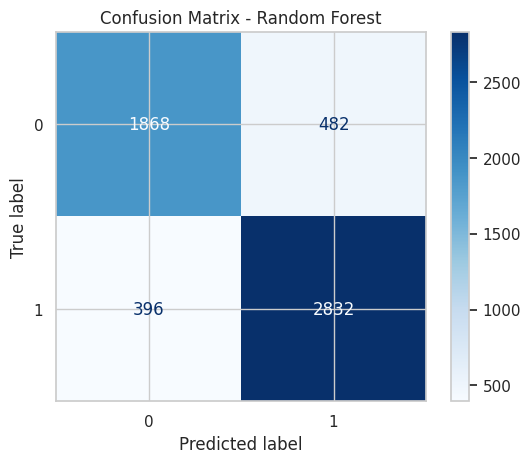

In [123]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test_encoded, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### Hyperparameter Tuning

In [126]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_encoded, y_train)

print("\nBest Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
